# Building a noise vocoder with Python

Created by Alexandre Chabot-Leclerc ([@AlexChabotL](http://twitter.com/alexchabotl)).

This notebook was created using Python 3 and the packages below. The following cell creates a `requirements.txt` file usable with [conda create](http://conda.pydata.org) or pip:

    conda create -n vocoder python=3 --file requirements.txt

It also contains interactive elements, so I recommend running it on your machine for full effect.

In [1]:
%%writefile requirements.txt
ipython-notebook
matplotlib
numpy
scipy
seaborn

Overwriting requirements.txt


## What's a vocoder?

The **[vocoder](https://en.wikipedia.org/wiki/Vocoder)**, short for *voice encoder* is an analysis and synthesis system that was originally designed as a method for encoding speech for transmission.

Similar to how MP3s reduce the size of a sound file, the vocoder's goal is to reduce the amount of "data" that has to be transmitted across the wire. To do so, the *encoding* portion of the vocoder analyzes the input signal in multiple frequency bands and extracts their slow-moving amplitude fluctuations, also called the *envelopes*. Because envelopes vary more slowly than the speech signal itself, it is then possible to reduce the envelopes' [sampling frequency](https://en.wikipedia.org/wiki/Nyquist–Shannon_sampling_theorem) without loss of information. In the *decoder*, the envelope of each frequency band is multiplied with a carrier signal (often noise).

The vocoder concept also has a few applications other than telecommunication. For example, it can be used for synthesizing speech, or to control electronic musical instruments. In hearing research, vocoders are often used to create speech-like sounds while controlling the complexity in the resulting signal.

In this notebook, we'll go through the steps necessary to create a noise vocoder in Python. On the way, we'll cover filter design and envelope extraction.

We'll start with a few imports we'll need later:

In [2]:
from __future__ import division, print_function
import numpy as np
from numpy import (arange, pi, zeros)
import scipy as sp
from scipy.io import wavfile
import scipy.signal
import matplotlib.pyplot as plt
import IPython
from IPython.display import display, Audio
plt.style.use('bmh')
%matplotlib inline


## Downloading and inspecting a speech signal

We'll download the sentence *[Cottage cheese with chives is delicious](http://www.ee.columbia.edu/~dpwe/sounds/sents/)*, from the [TIMIT](https://catalog.ldc.upenn.edu/LDC93S1) corpus of sentences, to work with:

In [3]:
!curl http://www.ee.columbia.edu/~dpwe/sounds/sents/sf3_cln.wav > audio.wav

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 79302  100 79302    0     0   154k      0 --:--:-- --:--:-- --:--:--  154k


We'll load the wav file from disk and immediately convert it to `float`. Scipy's `wavfile.read` reads wav files as `int` and it doesn't always play well with some of the processing we'll do later.

In [4]:
fs, cheese = wavfile.read('audio.wav')
cheese = cheese.astype('float')

 In addition to the signal `cheese`, `wavfile.read` also returns the signal's sampling frequency, `fs`, which is the number of samples per second. We'll need it to playback sound correctly, as well as for a few steps of the vocoder design.

It's now time to listen to the sentence:

In [5]:
Audio(data=cheese, rate=fs)

Let's have a look at the signal. We'll plot it as a function of time.

In [6]:
def plot_signal(x, fs):
    n = x.shape[-1]
    time = np.arange(n) / fs
    plt.plot(time, x)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

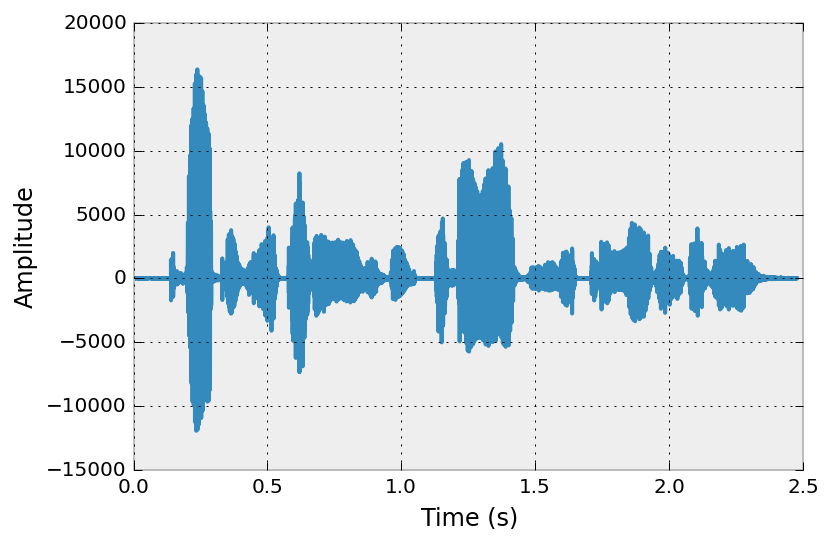

In [7]:
plot_signal(cheese, fs)

The largest amplitude sections are the vowels: the large peak between 0 and 0.5 seconds is the "o" of "cottage" and the large block between 1 and 1.5 seconds is the "i" from "chives". Vowels have much more energy than consonants. 

## Filtering a signal 

To create the vocoder, we will need to filter the signal using different band-pass filters. A filter's job is to let only some frequencies go through and to cut (attenuate) other ones. 

**Aside on frequencies**: Not familiar with frequencies? For the sake of example, lets say each key on a piano generates one frequency when you press it. If you make a chord (press multiple keys at once), you'll generate a single sound made of multiple frequencies. The unit of frequency is Hertz (Hz), and it means "cycles per second". So a 100 Hz tone has 100 cycles in one second.

Filters can have a few different shapes, but the most common ones are "low-pass", "high-pass" and "band-pass". A low-pass filter lets frequencies *below* a certain frequencies (called the *cutoff frequency*) go through (the results sounds a bit like being underwater). A high-pass filter lets only frequencies *above* a certain frequency go through (that's what DJ's use to build up tension before the beginning of a new *thumping* bass line). A band-pass filter let's only a *range* of frequencies through.

For the vocoder, we'll need a few band-pass filters, but let's start with designing and applying a single one. A band-pass filter can be defined by its bandwidth (in Hz), and its order (how steeply it attenuates frequencies outside of the pass band). Our filter will be one-third [octave](https://en.wikipedia.org/wiki/Octave) wide. An octave corresponds to a doubling in frequency, which means that 200 Hz is one octave about 100 Hz, and the 400 Hz is two octaves above 100 Hz. Here's a function that returns the "edges" of our third-octave wide filter centered at frequency `cf`:

In [8]:
def third_octave_bounds(cf):
    third_octave_ratio = 2 ** (1/6)  # 2 * 1/6 = 1/3
    return np.array([cf / third_octave_ratio, cf * third_octave_ratio])

The edges of a one-third octave wide filter centered at 1000 Hz are:

In [9]:
bounds = third_octave_bounds(1000)
'{:.2f} and {:.2f} Hz'.format(*bounds)

'890.90 and 1122.46 Hz'

We'll use a 4th-order [Butterworth](https://en.wikipedia.org/wiki/Butterworth_filter) filter for our vocoder. Butterworth filters have the nice property of having the flattest frequency response possible in the pass band. In the implementation below, the multiplication of `bounds` by `2 / fs` below is required because `scipy.signal.butter` expects a value between 0 and 1 for the filter cutoff frequencies, where 1 is half the sampling frequency.

In [10]:
def design_filter(bounds, fs):
    return sp.signal.butter(4, bounds * 2 / fs, btype='bandpass')

We can finally apply the filter to the sentence using Scipy's `lfilter` function. Our helper function will filter a signal `x`, with a third-octave wide filter centered at frequency `cf`:

In [11]:
from scipy.signal import lfilter

def bandpass_filter(x, cf, fs):
    bounds = third_octave_bounds(cf)
    num, den = design_filter(bounds, fs)
    return lfilter(num, den, x)

Have a listen. Different? The speech now sounds "narrow" and quieter.

In [12]:
y = bandpass_filter(cheese, 1000, fs)
Audio(y, rate=fs)

If we plot the filtered speech, we see that a lot of the energy that was in the original signal is gone (the original peaked around 15000). It makes sense, we took only a portion of the signal, therefore we end up with only a portion of the energy.

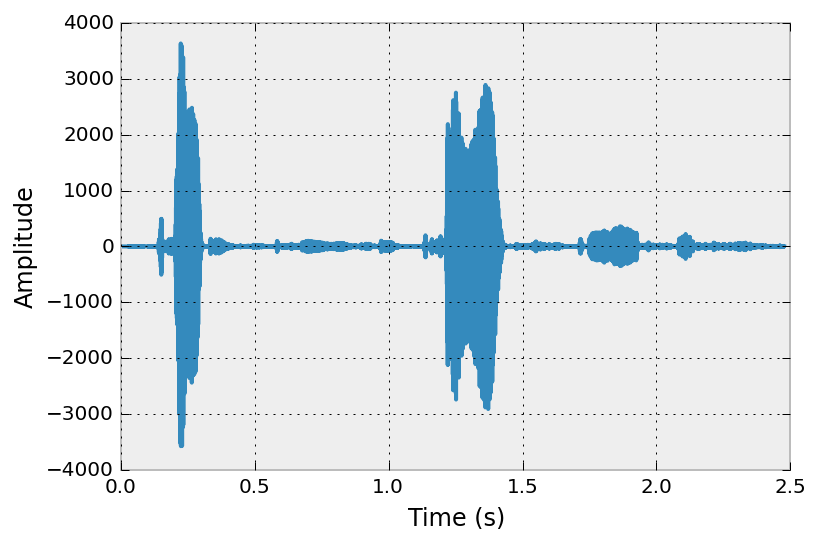

In [13]:
plot_signal(y, fs)

Here's a little interactive interface to try out the effect of selecting different center frequencies. The slider defines the center frequency of the band-pass filter.

In [14]:
from IPython.html.widgets import interact, fixed
from IPython.display import display

def audio_bandpass_filtered_signal(x, cf, fs):
    y = bandpass_filter(x, cf, fs)
    display(Audio(y, rate=fs))

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [15]:
interact(audio_bandpass_filtered_signal, cf=(100, 6000, 500), x=fixed(cheese), fs=fixed(fs))

### Filterbanks

A filterbank is simply a collection of filters. Typically, the filters are spaced according to a specific pattern across frequency. For example, they could be spaced by a fixed number of Hertz, or by a fixed ratio of frequencies. We'll opt for a ratio-based filterbank. The spacing between each filter will be one octave (the frequency will double each time).

Here's a function that returns octave-spaced frequencies between the lower and a higher bound.

In [16]:
def octave_spaced_frequencies(low, high):
    number_of_octaves = np.log2(high) - np.log2(low)
    return low * 2 ** arange(number_of_octaves)

For example, there are 4 octave-spaced frequencies between 100 Hz and 1000 Hz.

In [17]:
octave_spaced_frequencies(100, 1000)

array([ 100.,  200.,  400.,  800.])

Given a list of center frequencies, the following function will return a list of pairs of coefficients for each of our filters. 

**Note**: If you're interested in knowing more about filters, Scipy's `butter` returns coefficients for an [infinite impulse response](https://en.wikipedia.org/wiki/Infinite_impulse_response) (IIR) filter. We then apply those coefficient in a [digital filter](https://en.wikipedia.org/wiki/Digital_filter). I won't cover the details here.

In [18]:
def design_filterbank(center_frequencies, fs):
    boundaries = [third_octave_bounds(cf) for cf in center_frequencies]
    return [design_filter(bounds, fs) for bounds in boundaries]

In [19]:
center_frequencies = octave_spaced_frequencies(100, 201)
design_filterbank(center_frequencies, fs)

[(array([  4.22328822e-10,   0.00000000e+00,  -1.68931529e-09,
           0.00000000e+00,   2.53397293e-09,   0.00000000e+00,
          -1.68931529e-09,   0.00000000e+00,   4.22328822e-10]),
  array([  1.        ,  -7.97008822,  27.79717258, -55.41104193,
          69.05072424, -55.08284116,  27.46886141,  -7.82930454,   0.97651762])),
 (array([  6.67800184e-09,   0.00000000e+00,  -2.67120074e-08,
           0.00000000e+00,   4.00680110e-08,   0.00000000e+00,
          -2.67120074e-08,   0.00000000e+00,   6.67800184e-09]),
  array([  1.        ,  -7.92796005,  27.52245933, -54.64623661,
          67.87314748, -54.00080055,  26.87615485,  -7.65035058,   0.95358612]))]

We now have all the building blocks necessary to filter our signal through a filterbank that has a number of channels centered at selected center frequencies:

In [20]:
def apply_filterbank(x, center_frequencies, fs):
    n_samples = x.shape[-1]
    n_channels = len(center_frequencies)
    
    coefficients = design_filterbank(center_frequencies, fs)
    y = zeros((n_channels, n_samples))
    for idx, (b, a) in enumerate(coefficients):
        y[idx] = lfilter(b, a, x)
    return y

In [21]:
center_frequencies = octave_spaced_frequencies(100, 1001)
y = apply_filterbank(cheese, center_frequencies, fs)

We can listen to each channel separately. The results are similar to the single filters we applied above. Here's the signal for the 200 Hz channel.

In [22]:
channel_index = 1
print('Channel centered at {} Hz'.format(center_frequencies[channel_index]))
Audio(y[channel_index], rate=fs)

Channel centered at 200.0 Hz


The last step is to sum all the filtered channels together. If you imagine that the filters "cut" the signal into pieces, then summing the filter outputs is similar to gluing things back together; we end up with more or less the signal we filtered in the first place. The "more or less" depends on the bandwidth of the filters, the spacing between them, their number, and their overlap.

In [23]:
y = np.sum(y, axis=0)

In [24]:
Audio(y, rate=fs)

Is the speech still understandable? It should be. In fact, it's quite impressive, since we just threw away most of the signal. To illustrate this point, let's have a look at the spectrogram of the original and of the filtered sentence. A spectrogram is a *time-frequency* representation of the energy in the signal. Below, the spectrogram of the original signal is on the left, and the spectrogram of the filtered speech is on the right. Time is on the horizontal axis, frequency is on the vertical axis, and the intensity of the color represents the amount of energy.

In [25]:
def compare_spectrogram(x, y, fs):
    """Plots spectrogram of x, the original, and y, the modified signal."""
    fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

    p_x, *_, im  = axes[0].specgram(x, cmap='Blues', Fs=fs)
    vmin, vmax = 10 * np.log10([np.min(p_x), np.max(p_x)])
    _ = axes[1].specgram(y, cmap='Blues', Fs=fs, vmin=vmin, vmax=vmax)
    axes[0].set_title('Original')
    axes[1].set_title('Modified')
    for ax in axes:
        ax.set_xlabel('Time (s)')
        ax.grid(False)
    axes[0].set_ylabel('Frequency (Hz)')
    cbar = fig.colorbar(im)
    cbar.ax.set_ylabel('Magnitude (dB)')
    fig.tight_layout()

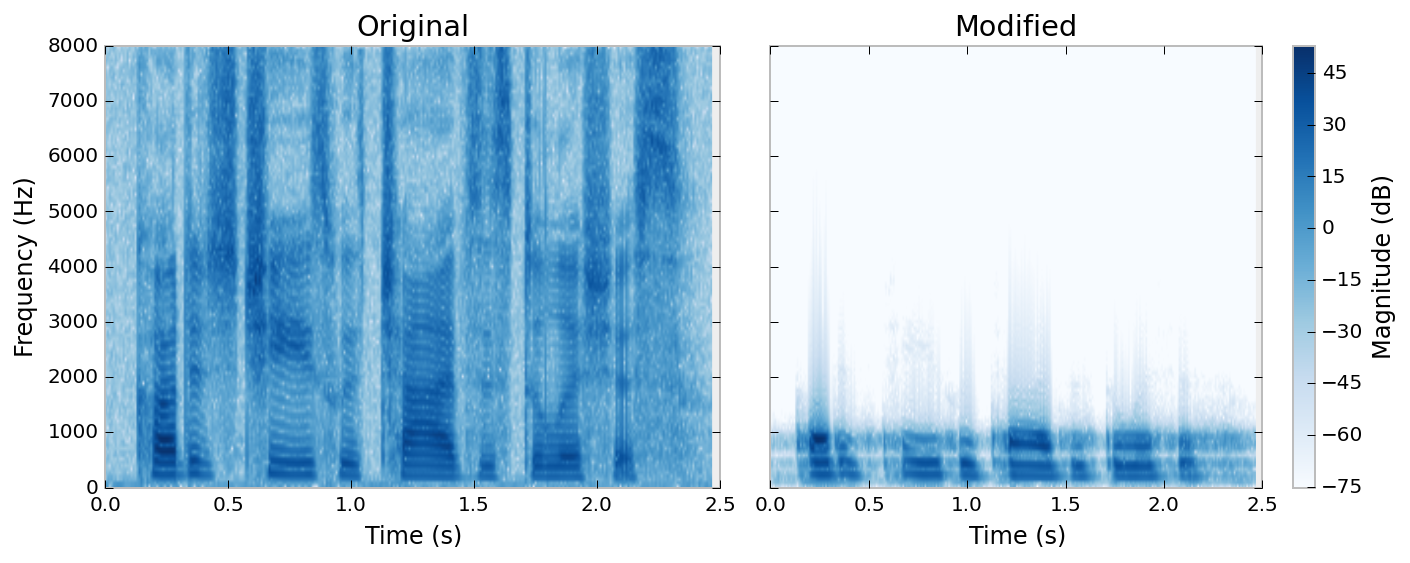

In [26]:
compare_spectrogram(cheese, y, fs)

As we can see, there's almost no energy above 1000 Hz in our modified signal, which is expected, since the highest cutoff frequency of our band-pass filter was:

In [27]:
highest_cutoff = third_octave_bounds(center_frequencies[-1])[-1]
'Highest cutoff frequency: {:.2f} Hz'.format(highest_cutoff)

'Highest cutoff frequency: 897.97 Hz'

## Extracting the envelopes

As mentioned in the introduction, one of the goals of the vocoder design was to reduce the amount of information that had to be transmitted. In order to do so, the vocoder extracts the envelope of the signal, which means the shape of the slow fluctuations in the signal.

We'll extract the envelope by taking the absolute value of our signal (i.e., making all samples positive) and then low-pass filtering it. The cutoff frequency and the order of the low-pass filter define how much information we're throwing away. The lower cutoff frequency, the less information left. A first order filter with a 20 Hz cutoff frequency is a good place to start.

In [28]:
def extract_envelope(x, cutoff=20, order=1):
    envelope = np.abs(x)
    b, a = sp.signal.butter(order, cutoff * 2 / fs)
    low_pass_filtered_envelope = sp.signal.lfilter(b, a, envelope)
    return low_pass_filtered_envelope

In [29]:
envelope = extract_envelope(cheese)

As we can see below, the envelope (in green) captures the slow fluctuations in the signal's amplitude (in blue).

In [30]:
def plot_signal_and_envelope(x, envelope, fs):
    fig, ax = plt.subplots()
    t = arange(x.shape[-1]) / fs
    ax.plot(t, x, label='signal')
    ax.plot(t, envelope, label='envelope')
    ax.legend(loc='best')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')    

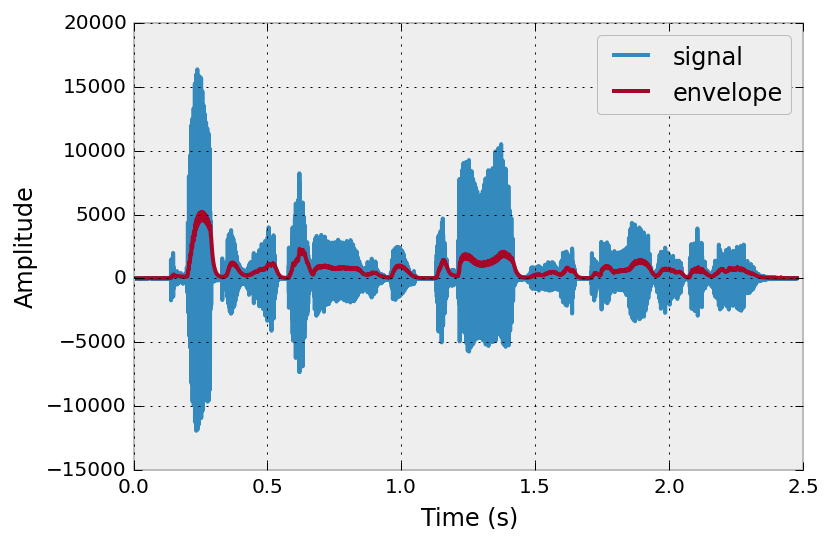

In [31]:
plot_signal_and_envelope(cheese, envelope, fs)

It's easier to see how the envelope capture the slow fluctuations if we look at only a section of the signals:

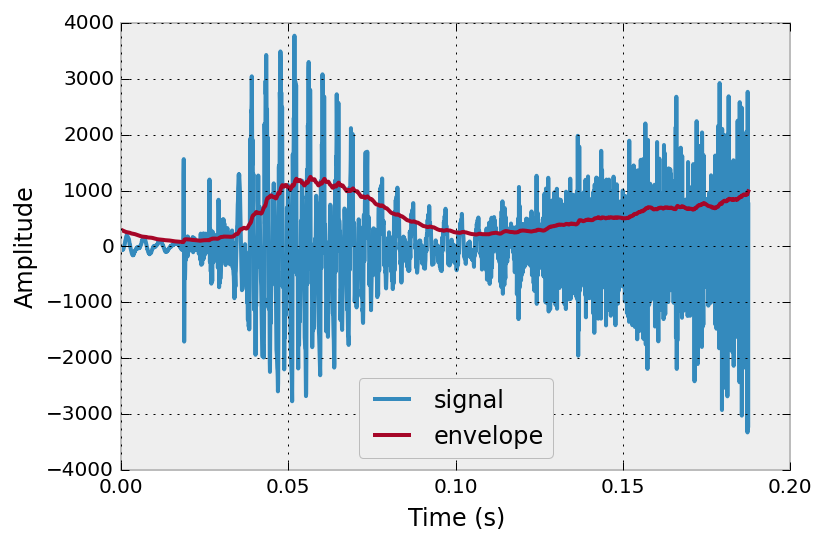

In [32]:
section = slice(5000, 8000)
plot_signal_and_envelope(cheese[section], envelope[section], fs)

Here's a little interactive widget to explore how different low-pass cutoff frequencies capture more or less of the amplitude fluctuations in the signal. How low do you think we could go before the speech becomes unintelligible?

In [33]:
def plot_cutoff_frequency_effect(cutoff):
    envelope = extract_envelope(cheese, cutoff=cutoff)
    plot_signal_and_envelope(cheese, envelope, fs)

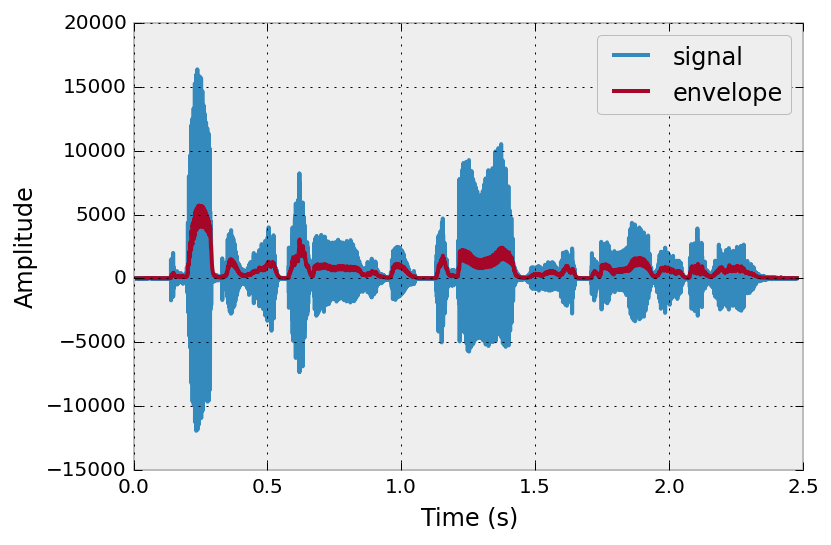

In [34]:
interact(plot_cutoff_frequency_effect, cutoff=(1, 101, 5))

## The decoder portion of the vocoder

We now consider the "receiving" portion of the vocoder, the *decoder*. The decoder receives our encoded signal (the envelopes), which it must then convert back to "speech". The problem we're facing is that we don't have access to the "fine structure" (the fast fluctuations in the speech) anymore, so we'll need to replace it with something: noise in this case.

A simple white noise (a noise with a flat spectrum) will do the trick:

In [35]:
noise = np.random.randn(*cheese.shape)

We then apply the envelopes to that noise. In the simplest case, we can extract the envelope of the original speech and apply it directly to the noise:

In [36]:
envelope = extract_envelope(cheese)
vocoded_noise = envelope * noise
Audio(data=vocoded_noise, rate=fs)

Not really interesting, nor intelligible… What we need to do is to apply the band-specific envelopes we extracted above to noise filtered with the corresponding band-pass filters. It's finally time to build our vocoder!

The steps go as follows: create a noise of the same length as the input speech; filter the speech and noise using the same filterbank; "zip" through each pair of speech and noise bands extract the envelope of the speech signal and apply it to the noise and save the result. We finish by summing up all the channels.

In [37]:
def vocode(x, center_frequencies, fs):
    n_channels = len(center_frequencies)
    n_samples = x.shape[-1]
    noise = np.random.randn(n_samples) 

    filtered_x = apply_filterbank(x, center_frequencies, fs)
    filtered_noise = apply_filterbank(noise, center_frequencies, fs)
    
    vocoded_noise = np.zeros((n_channels, n_samples))
    for idx, (x_band, noise_band) in enumerate(zip(filtered_x, filtered_noise)):
        envelope = extract_envelope(x_band)
        vocoded_noise[idx] = envelope * noise_band
    return np.sum(vocoded_noise, axis=0)

Finally, here's how vocoded speech sounds like:

In [38]:
center_frequencies = octave_spaced_frequencies(100, 6000)
vocoded_cheese = vocode(cheese, center_frequencies, fs)
print('Vocoded speech with bands: {} Hz.'.format(center_frequencies))
Audio(vocoded_cheese, rate=fs)

Vocoded speech with bands: [  100.   200.   400.   800.  1600.  3200.] Hz.


That should be pretty easy to understand. In the spectrogram of the original speech (left) and of the vocoded speech (right), we can see how all the fine details are lost. Considering how much information we've removed, it's pretty amazing that we're still able to understand anything. Note that we're cheating a bit: we've heard the clean sentence before, therefore our brain has an easier time reconstructing the meaning of the sentence from the vocoded speech. It's harder if you've never heard the sentences before, but it's still possible.

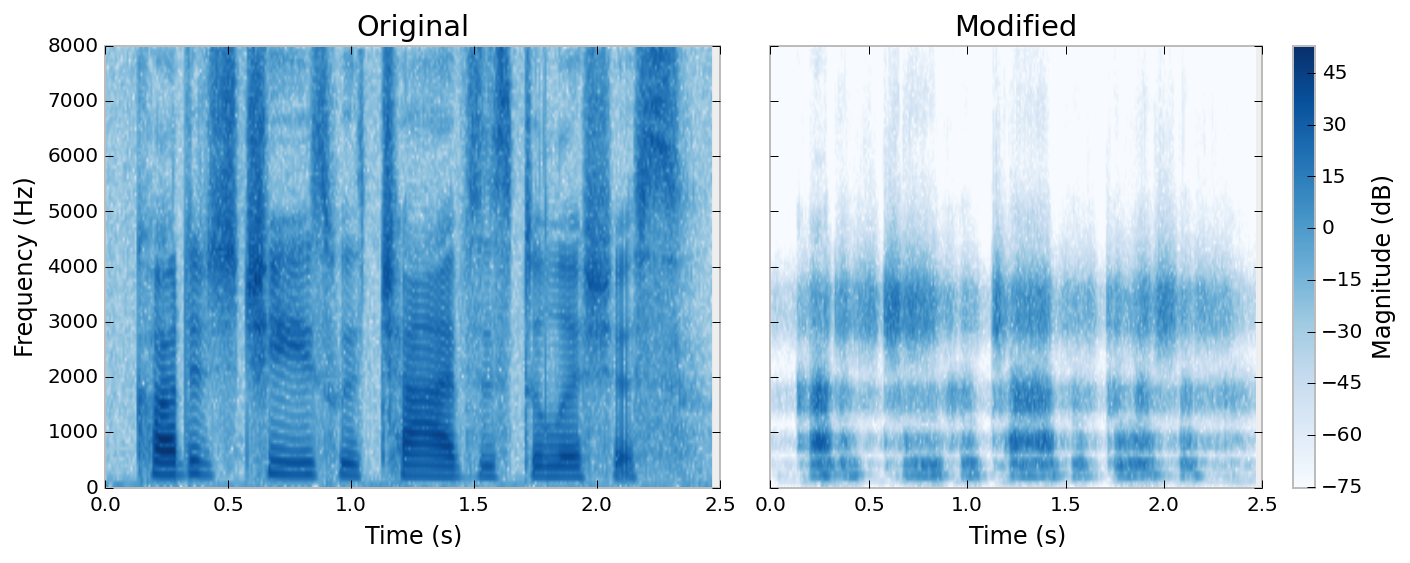

In [39]:
compare_spectrogram(cheese, vocoded_cheese, fs)

Below, we can experiment with which bands to use in the vocoder. Some of them carry more speech information than others.

In [40]:
from collections import OrderedDict
from IPython.html.widgets import Checkbox


def create_cf_checkboxed(center_frequencies):
    center_frequency_checkboxes = {}
    for cf in center_frequencies:
        cf_string = '{}'.format(cf)
        center_frequency_checkboxes[cf_string] = Checkbox(True, description=cf_string)
    return center_frequency_checkboxes

def combine_center_frequencies(**kwargs):
    center_frequencies = np.array([float(cf) for cf, state in kwargs.items() if state])
    vocoded_cheese = vocode(cheese, center_frequencies, fs)
    cf_strings = ['{:.0f}'.format(cf) for cf in sorted(center_frequencies)]
    cf_string = ', '.join(cf_strings)
    compare_spectrogram(cheese, vocoded_cheese, fs)
    print('Speech vocoded with bands: {} Hz.'.format(cf_string))
    display(Audio(vocoded_cheese, rate=fs))

Speech vocoded with bands: 100, 200, 400, 800, 1600, 3200 Hz.


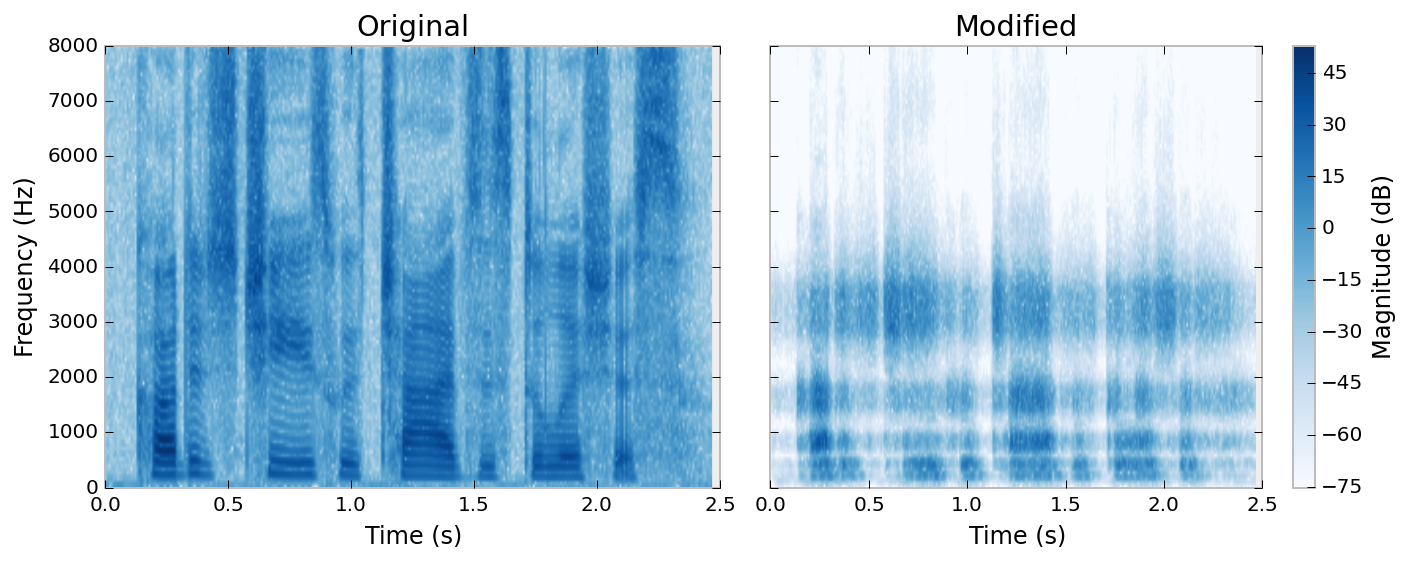

In [41]:
center_frequencies = octave_spaced_frequencies(100, 6001)
center_frequency_checkboxes = create_cf_checkboxed(center_frequencies)
interact(combine_center_frequencies, **center_frequency_checkboxes)

## What next?

We've built a noise-vocoder "from scratch". On the way we've made a few decision: we've fixed the filters bandwidth and their spacing, we've chosen a cutoff frequency of 20 Hz for the envelope extraction, and we've chosen noise as our reconstruction signal. 

Below are a few ideas of things we could do now that we have a basic vocoder:

- In the reconstruction, replace the filtered noise by a sinusoid at the corresponding center frequency. The result would be called a sine-vocoder.
- Experiment with the filter bandwidths and spacing.
- What's the minimum number of channels necessary to have understandable speech?
- How to you define "understandable speech"?
- Calculate the "compression ratio" between one second of speech sampled at 16 kHz compared to the envelopes extracted by the encoding portion of the vocoder. How much more space do you need to store the original speech?
- The vocoder would probably make more sense as a class, rather than as a collection of functions. The exercise is left to the reader. :)



<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" href="http://purl.org/dc/dcmitype/Text" property="dct:title" rel="dct:type">Building a noise vocoder with Python</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="http://twitter.com/alexchabotl" property="cc:attributionName" rel="cc:attributionURL">Alexandre Chabot-Leclerc</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.